In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [56]:
df=pd.read_csv('data/checkoutstimeseries.csv',parse_dates=['Year-Month'])
df.head()


,Unnamed: 0,Year-Month,BOOK,EBOOK,SOUNDDISC,VIDEODISC,AUDIOBOOK,Other
0,0,2005-04-01,143053,0,37432,32157,0,40021
1,1,2005-05-01,227864,0,58138,53305,0,62088
2,2,2005-06-01,287908,0,70580,67821,0,76130
3,3,2005-07-01,195018,0,49752,48457,0,50441
4,4,2005-08-01,210033,0,55664,53192,0,54818


In [57]:
df.columns

Index(['Unnamed: 0', 'Year-Month', 'BOOK', 'EBOOK', 'SOUNDDISC', 'VIDEODISC',
       'AUDIOBOOK', 'Other'],
      dtype='object')

In [58]:
#We don't need the first column, so we drop it.
df = df.drop('Unnamed: 0', axis=1)


In [59]:
df.head()

,Year-Month,BOOK,EBOOK,SOUNDDISC,VIDEODISC,AUDIOBOOK,Other
0,2005-04-01,143053,0,37432,32157,0,40021
1,2005-05-01,227864,0,58138,53305,0,62088
2,2005-06-01,287908,0,70580,67821,0,76130
3,2005-07-01,195018,0,49752,48457,0,50441
4,2005-08-01,210033,0,55664,53192,0,54818


In [60]:
#Our data is unreliable after April of 2024, so we drop the rows after this.

df = df.drop(df[df['Year-Month'] > pd.to_datetime('2024-04-01') ].index)

In [61]:
df.tail()

,Year-Month,BOOK,EBOOK,SOUNDDISC,VIDEODISC,AUDIOBOOK,Other
224,2023-12-01,218063,271133,14063,46244,220101,8465
225,2024-01-01,249991,286052,14163,48465,241287,9470
226,2024-02-01,227572,257818,14385,45266,218335,9008
227,2024-03-01,240492,269650,14148,47753,232102,9279
228,2024-04-01,232015,258261,13424,44527,221409,9053


In [62]:
from sklearn.model_selection import train_test_split

In [63]:
#Make our test-train-split
df_train=df[df['Year-Month']< pd.to_datetime('2023-05-01')]
df_test=df[df['Year-Month']>= pd.to_datetime('2023-05-01')]

In [64]:
df_test.head(13)

,Year-Month,BOOK,EBOOK,SOUNDDISC,VIDEODISC,AUDIOBOOK,Other
217,2023-05-01,234008,245842,13735,42223,199974,7133
218,2023-06-01,243120,244555,13883,42370,201215,7520
219,2023-07-01,254000,264058,13274,42414,212350,7989
220,2023-08-01,259623,262905,14209,44633,217048,8623
221,2023-09-01,239205,252549,12838,42896,208961,8168
222,2023-10-01,242487,260825,12756,44176,216269,8671
223,2023-11-01,229088,255659,12904,42698,211135,8650
224,2023-12-01,218063,271133,14063,46244,220101,8465
225,2024-01-01,249991,286052,14163,48465,241287,9470
226,2024-02-01,227572,257818,14385,45266,218335,9008


Now, we want to some time series forecasting.

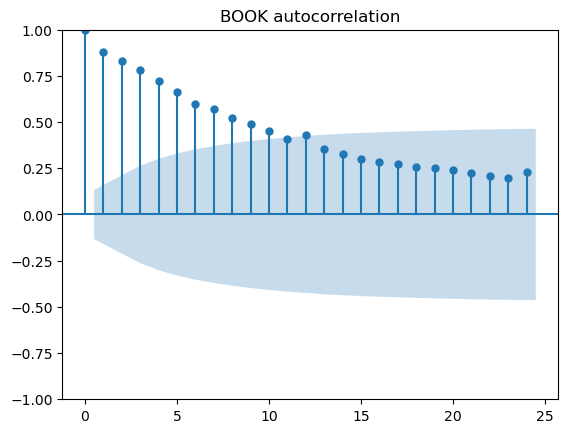

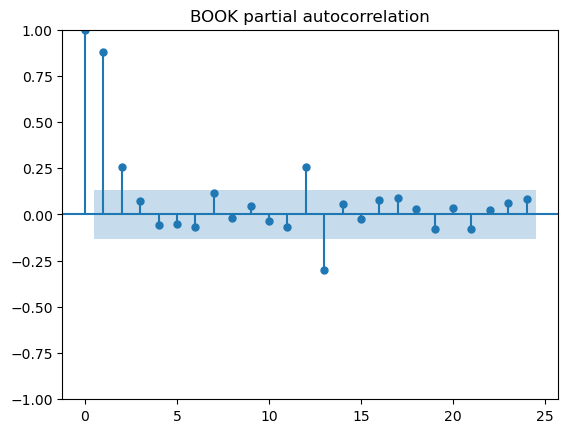

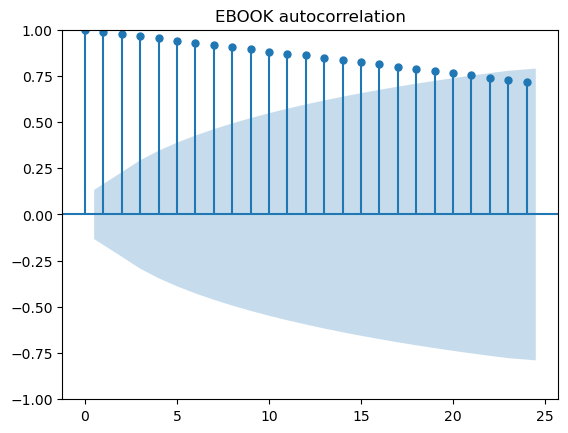

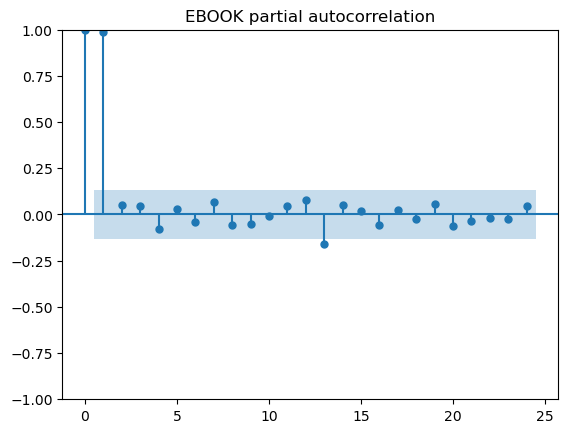

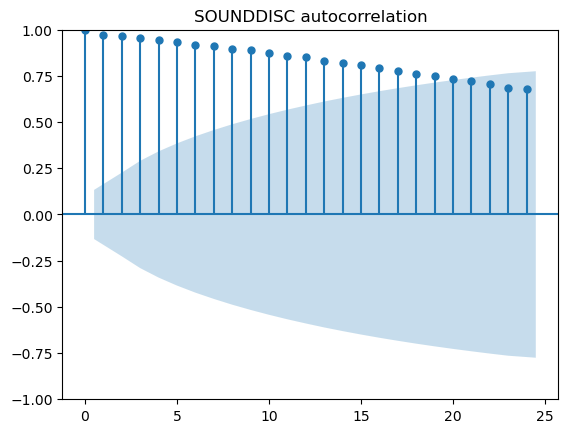

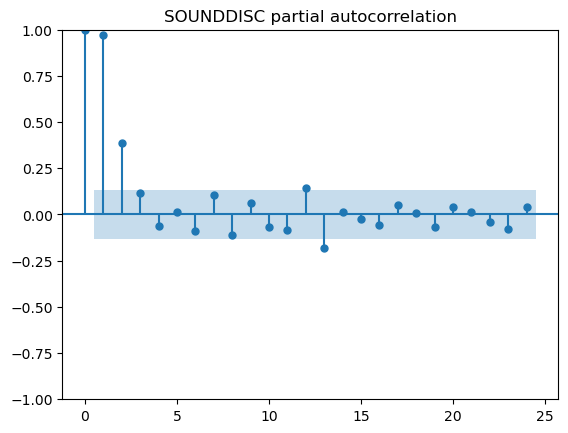

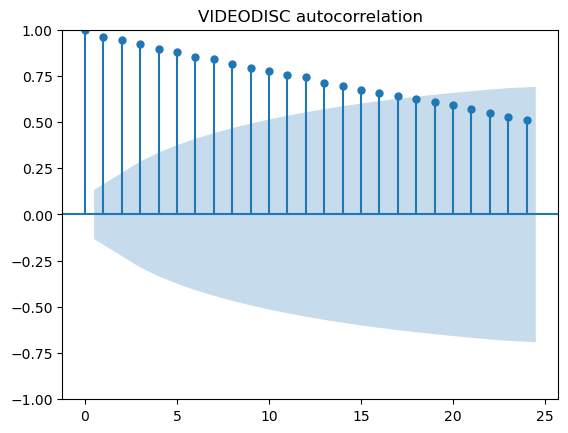

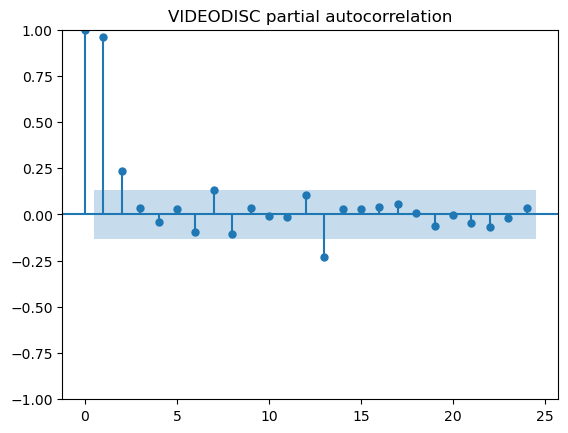

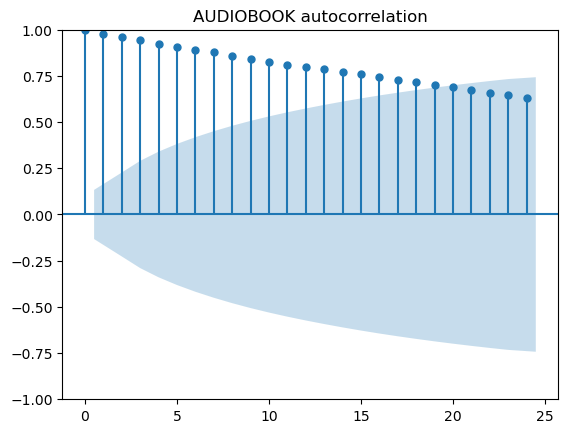

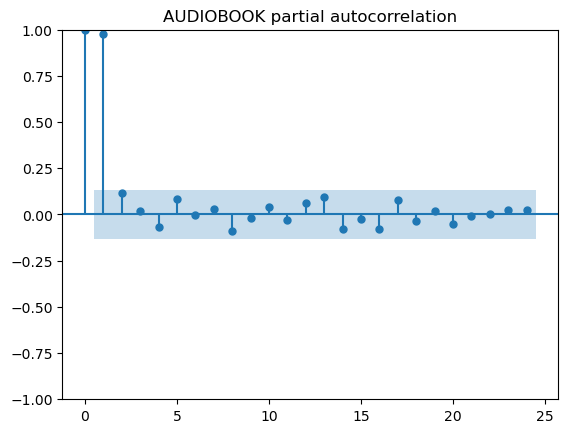

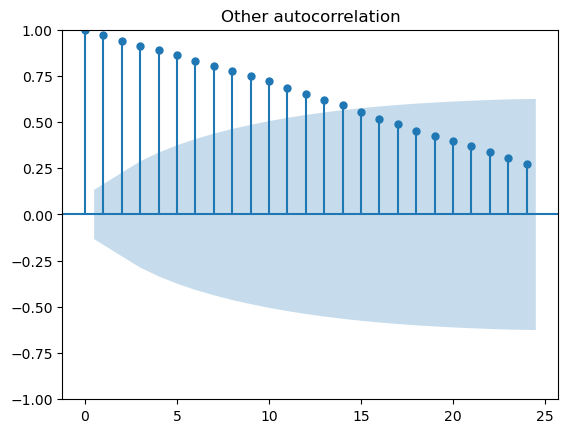

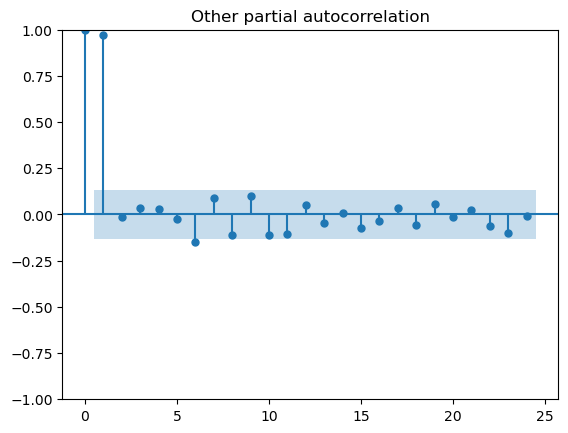

In [65]:
#Let's see how much autocorrelation there is

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#get list of materials forecast for
materials=['BOOK','EBOOK','SOUNDDISC','VIDEODISC','AUDIOBOOK','Other']

for x in materials:
    plot_acf(df_train[x])
    plt.title(x + ' autocorrelation')
    plot_pacf(df_train[x])
    plt.title(x + ' partial autocorrelation')
    plt.show


It looks like some of the plots may have some 12 month seasonality based on the peaks in PACF, but the effect doesn't appear very strong. Let's look at some pictures to get a sense of the overall trends.

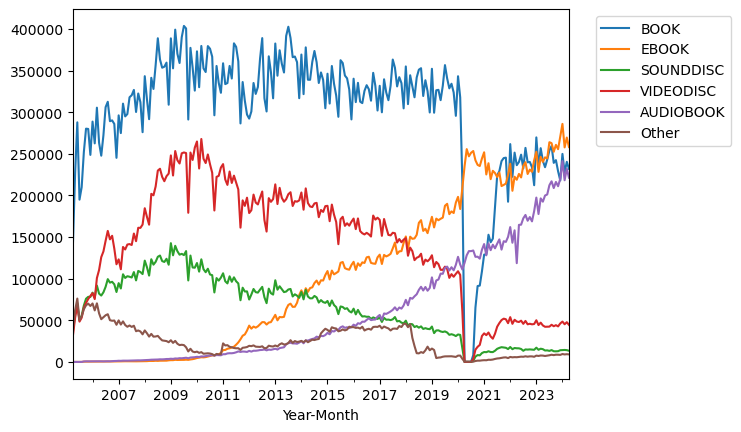

In [66]:


df.plot(x='Year-Month', y=['BOOK', 'EBOOK','SOUNDDISC',  'VIDEODISC' ,'AUDIOBOOK', 'Other'])

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

plt.show()

It looks like there is a linar trend in books, videodiscs, sound discs, and ebooks, and an exponential trend in audiobooks. I don't see any seasonality in these plots, but that could be lost in the overall trend. 

Before doing forecasting, I will try to substract out some trends.

I'll fit a degree 3 polynomial to the data, then subtract that.



In [67]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [68]:
trendpipeline=Pipeline([('polyfeatures',PolynomialFeatures(3, interaction_only=False, include_bias=False)),
                        ('regression',LinearRegression())])

In [69]:
#make a pandas dataframe  to store the trend 
df_train_trend=df_train.__deepcopy__()

for feature in materials:
    trendpipeline.fit(X=np.array(df_train.index).reshape(-1,1),y=df_train[feature])
    prediction=trendpipeline.predict(X=np.array(df_train.index).reshape(-1,1))
    df_train_trend[feature]=prediction


<Figure size 1000x500 with 0 Axes>

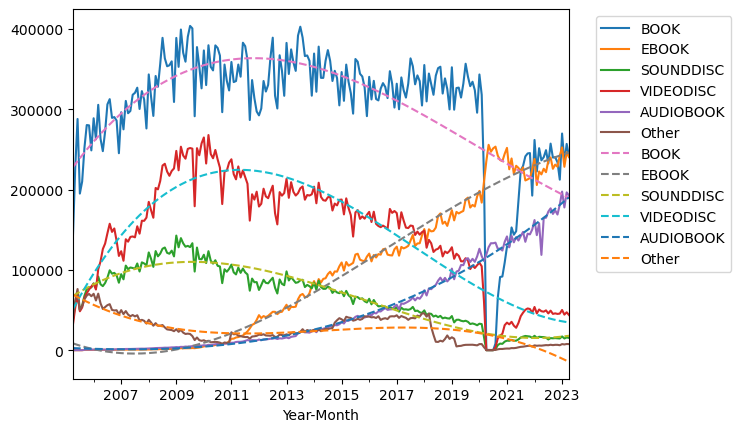

In [70]:
#plot both the raw data and the trend.
plt.figure(figsize=(10,5))
ax=df_train.plot(x='Year-Month', y=['BOOK', 'EBOOK','SOUNDDISC',  'VIDEODISC' ,'AUDIOBOOK', 'Other'])
df_train_trend.plot(x='Year-Month', y=['BOOK', 'EBOOK','SOUNDDISC',  'VIDEODISC' ,'AUDIOBOOK', 'Other'], ls="--", ax=ax)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

plt.show()

Now, we subtract the trend and examine the resulting plot.

<Figure size 1000x500 with 0 Axes>

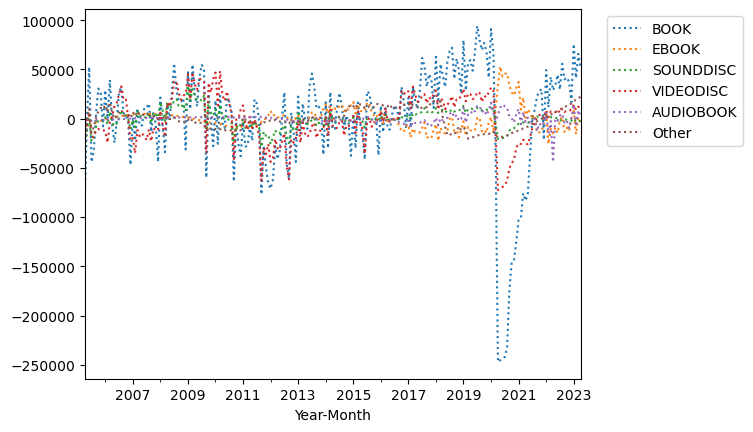

In [71]:
#subtract the trend.

df_train_no_trend=df_train.__deepcopy__()

for feature in materials:
    df_train_no_trend[feature]=df_train[feature]-df_train_trend[feature]

plt.figure(figsize=(10,5))

df_train_no_trend.plot(x='Year-Month', y=['BOOK', 'EBOOK','SOUNDDISC',  'VIDEODISC' ,'AUDIOBOOK', 'Other'], ls=":")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()


Before we do our modeling, we plot the ACFS and PACFS with the trend subtracted.

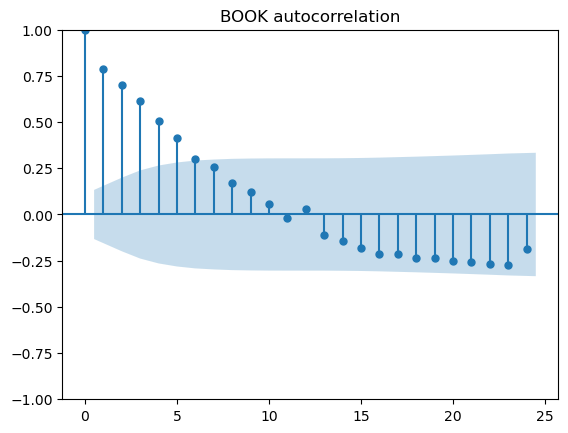

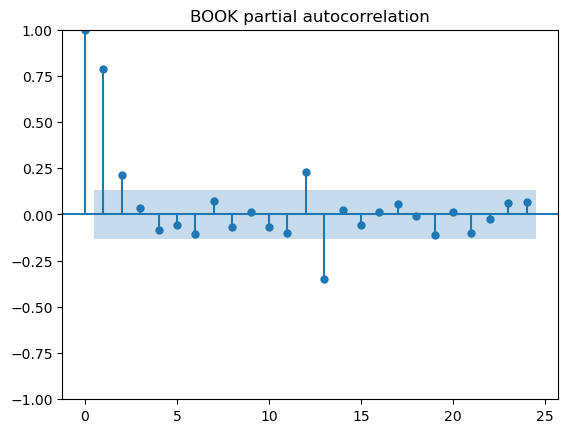

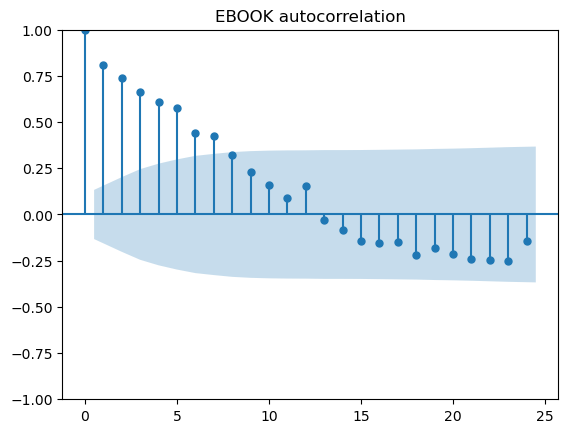

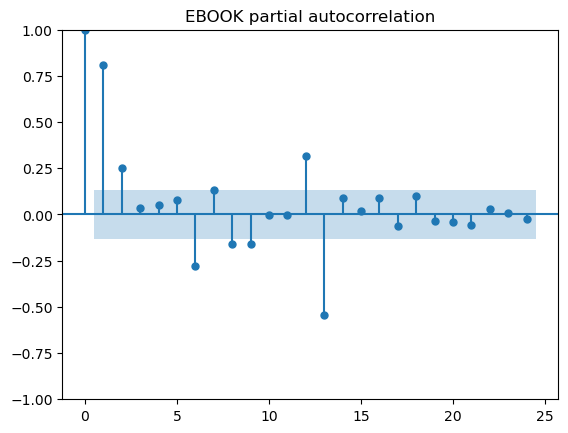

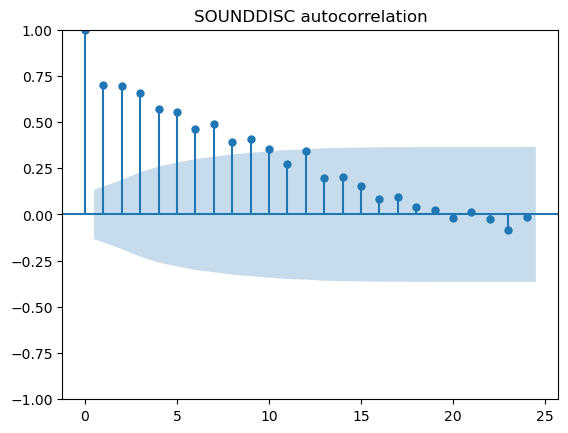

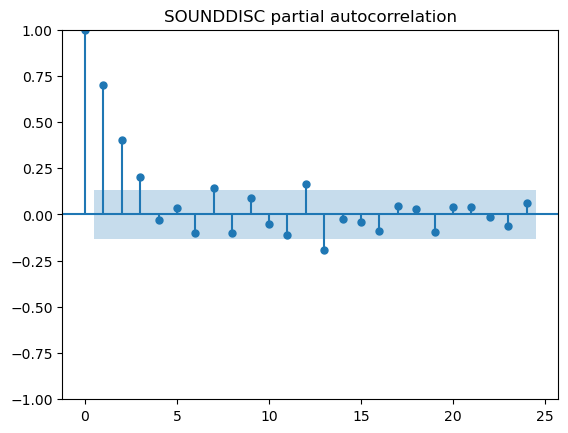

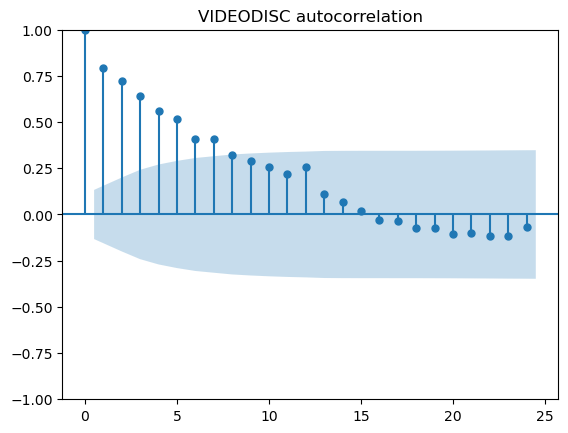

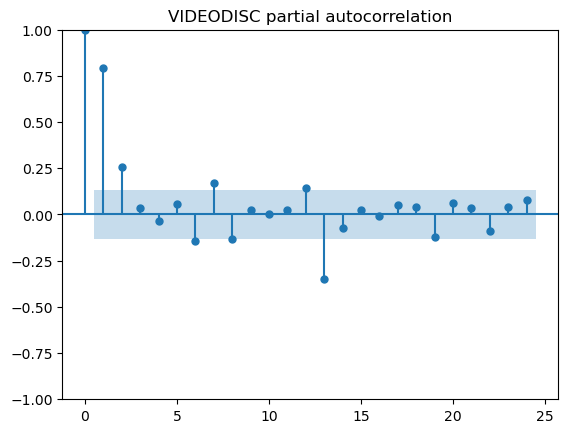

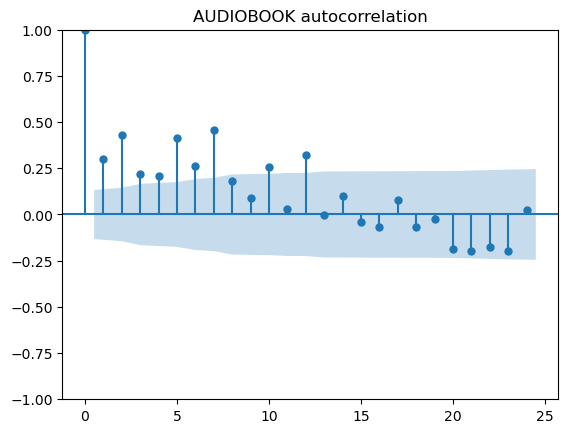

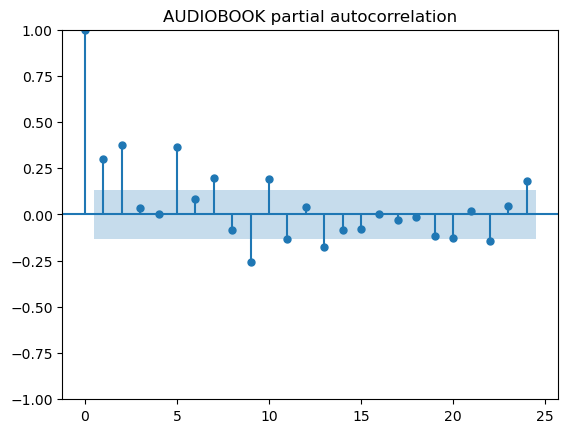

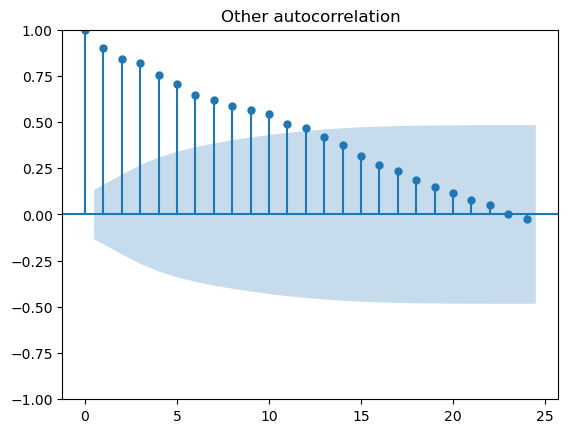

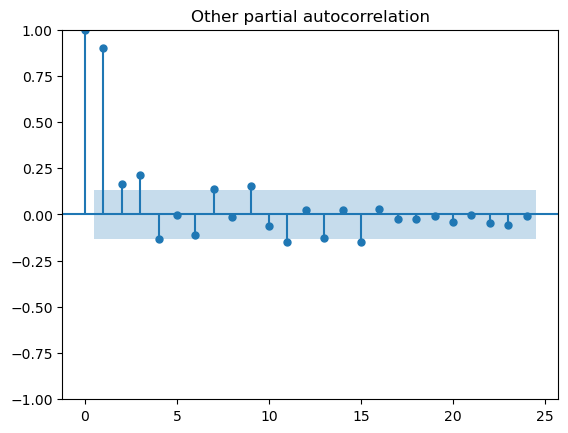

In [72]:
for x in materials:
    plot_acf(df_train_no_trend[x])
    plt.title(x + ' autocorrelation')
    plot_pacf(df_train_no_trend[x])
    plt.title(x + ' partial autocorrelation')
    plt.show

We see that in most categories the PACF have bigger spikes at 12 and 13 months.

Now, we do some modeling with ARIMA. First, we make our cross validation splits.

In [73]:
from sklearn.model_selection import TimeSeriesSplit

In [74]:
tscv=TimeSeriesSplit(n_splits=12, test_size=1)



Our Naive model will be linear regression. We will also use AutoArima, and Autoarima on the data with the trend taken out (then added back) and seasonality set to 12.

In [110]:
import pmdarima as pm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error as rmse

In [76]:
baseline_linear=LinearRegression()


In [77]:
#make 3 dataframe for predictions
df_baseline_preds=pd.DataFrame(index=df.index, columns=materials)

df_autoarima_preds=pd.DataFrame(index=df.index, columns=materials)

df_autoarima_no_trend_withseasonality_preds=pd.DataFrame(index=df.index, columns=materials)



In [78]:

for train_index, test_index in tscv.split(df_train):
    df_tt = df_train.iloc[train_index]
    df_ho = df_train.iloc[test_index]
    print(test_index)
    for feature in materials:
        #fit the three models
        baseline_linear.fit(X=np.array(train_index).reshape(-1,1),y=df_tt[feature])
        autoarima=pm.auto_arima(df_tt[feature])
        trendpipeline.fit(X=np.array(train_index).reshape(-1,1),y=df_tt[feature])
        prediction_of_trend=trendpipeline.predict(X=np.array(train_index).reshape(-1,1))
        data_without_trend=df_tt[feature]-prediction_of_trend
        autoarima_no_trend_with_seasonality=pm.auto_arima(data_without_trend, m=12)
        #the m parameter in autoarima is supposed to control seasonality.

        df_baseline_preds.loc[test_index,feature]=baseline_linear.predict(X=np.array(test_index).reshape(-1,1))
        df_autoarima_preds.loc[test_index,feature]=autoarima.predict(n_periods=1)
        df_autoarima_no_trend_withseasonality_preds.loc[test_index,feature]=autoarima_no_trend_with_seasonality.predict(n_periods=1)+trendpipeline.predict(X=np.array(test_index).reshape(-1,1))

[205]
[206]
[207]
[208]
[209]
[210]
[211]
[212]


/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,4)(2,0,0)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "/opt/

[213]
[214]
[215]
[216]


In [79]:


df_baseline_preds['Year-Month']=df['Year-Month']
df_autoarima_preds['Year-Month']=df['Year-Month']
df_autoarima_no_trend_withseasonality_preds['Year-Month']=df['Year-Month']

# df_autoarima_no_trend_withseasonality_preds.head()

<Figure size 1000x500 with 0 Axes>

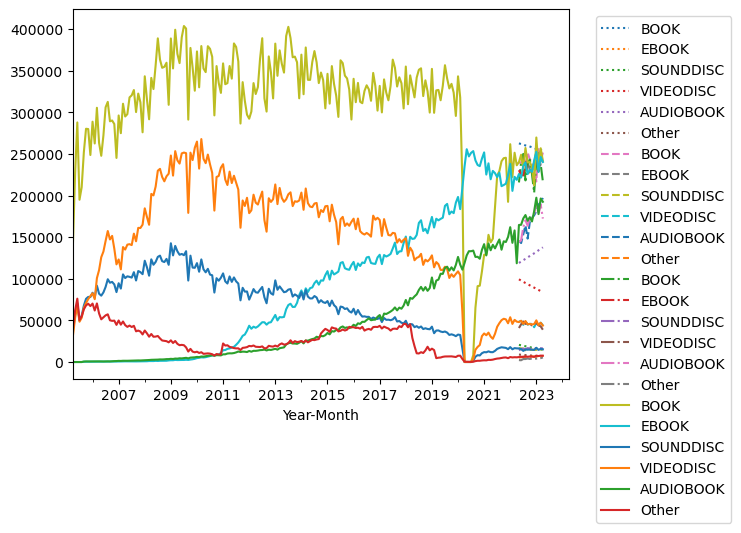

In [ ]:
plt.figure(figsize=(10,5))
ax=df_baseline_preds.plot(x='Year-Month', y=['BOOK', 'EBOOK','SOUNDDISC',  'VIDEODISC' ,'AUDIOBOOK', 'Other'],ls=":")
df_autoarima_preds.plot(x='Year-Month', y=['BOOK', 'EBOOK','SOUNDDISC',  'VIDEODISC' ,'AUDIOBOOK', 'Other'],ls="--", ax=ax)
df_autoarima_no_trend_withseasonality_preds.plot(x='Year-Month', y=['BOOK', 'EBOOK','SOUNDDISC',  'VIDEODISC' ,'AUDIOBOOK', 'Other'],ls='-.',ax=ax)
df_train.plot(x='Year-Month', y=['BOOK', 'EBOOK','SOUNDDISC',  'VIDEODISC' ,'AUDIOBOOK', 'Other'],ax=ax)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

plt.show()

#to do: make this figure with more sensisble colors and legend. Only show the year of predictions. 

Now, we get the mean squared error of our predictions.

In [82]:
df_errors=pd.DataFrame(index=['Baseline', 'AutoArima', 'AutoArimawithoutTrend'], columns=materials)

In [84]:
df_autoarima_no_trend_withseasonality_preds.tail(30)

,BOOK,EBOOK,SOUNDDISC,VIDEODISC,AUDIOBOOK,Other,Year-Month
199,NaN,NaN,NaN,NaN,NaN,NaN,2021-11-01
200,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-01
201,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01
202,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-01
203,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-01
204,NaN,NaN,NaN,NaN,NaN,NaN,2022-04-01
205,215826.730701,230518.334675,14016.280932,40887.926892,144022.948714,2311.822033,2022-05-01
206,239636.966048,224670.577335,15626.054104,45286.624743,146273.070382,2124.521789,2022-06-01
207,250057.511582,224466.803303,16181.765052,48712.294378,162100.975344,3595.398826,2022-07-01
208,218278.881246,241717.139892,15388.496013,45759.822616,170310.090536,3596.047616,2022-08-01


In [ ]:
#to do: refactor this to be a nested for loop over the models, instead of copying something 3 times
for feature in materials:
    df_errors.loc['Baseline',feature]=rmse(y_true=df_train.loc[205:216][feature], y_pred=df_baseline_preds.loc[205:216][feature])
for feature in materials:
    df_errors.loc['AutoArima',feature]=rmse(y_true=df_train.loc[205:216][feature], y_pred=df_autoarima_preds.loc[205:216][feature])
for feature in materials:
    df_errors.loc['AutoArimawithoutTrend',feature]=rmse(y_true=df_train.loc[205:216][feature], y_pred=df_autoarima_no_trend_withseasonality_preds.loc[205:216][feature])

In [114]:
df_errors.head()

,BOOK,EBOOK,SOUNDDISC,VIDEODISC,AUDIOBOOK,Other
Baseline,21786.723688,9501.078326,3216.909852,45040.005636,50365.3569,1606.195251
AutoArima,20705.749966,10621.341565,1221.599528,1468.966489,13932.623535,685.33117
AutoArimawithoutTrend,19204.316447,4511.398433,1505.292956,3499.886357,11176.020182,2933.576266
